In [18]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob



## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

%matplotlib inline

In [19]:
#Set grid parameters
num_rows = 200
num_columns = 200
node_spacing = 1.00
node_next_to_outlet = num_columns + 1


#Set Model Time Parameters
timestep = 100.0
run_time = 10000 #years

uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)


#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')

#topographic roughness
#random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid


#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#adding roughness
#mg.at_node["bedrock__elevation"] += (mg.node_y / 10. + mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.0)
topo = mg.node_y/10 + mg.node_x/10

#topographic roughness
random_noise = np.random.rand(len(mg.node_y)) /10 #impose topography values on model grid
mg['node']['topographic__elevation'] += (topo + random_noise) 

mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]


#mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
#mg.at_node["topographic__elevation"][:] = mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
print(outlet_node)

None


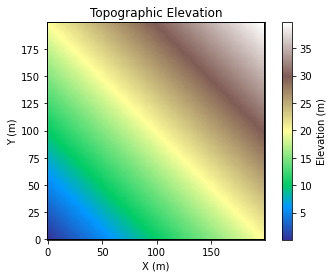

In [20]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [21]:
#Parameters for SPACE and Fastscape
K_sed = 0.01
K_sp = 0.001
K_br = 0.001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)  

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)

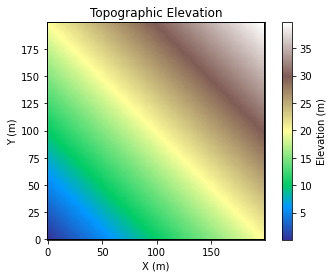

In [22]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [23]:
sp_fsc_yrs = np.arange(0, 5000, 1000) #for every 5 million yrs space will run for 10 years
fsc_img_interval = np.arange(0, 100, 10) #creates a numpy array with numbers in the interval of 1000 between 1 and the 100000
fsc_timestep = 100
fsc_uplift_rate = .001
fsc_tot_uplift = fsc_timestep*fsc_uplift_rate #total uplift per timestep


#run for 10 years
for x in range(10000):
    #mg.at_node['bedrock__elevation'][:] += uplift_per_timestep  #adding uplift to the bedrock
    #mg.at_node['topographic__elevation'][:]= mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    mg.at_node["topographic__elevation"][0] -= 0.001 # Uplift
    mg.at_node["bedrock__elevation"][0] -= 0.001 # Uplift
    #if x in sp_fsc_yrs:
        #then run space
        #fa.run_one_step()
        #sp.run_one_step(100)
        #continue
    fa.run_one_step()
    df.map_depressions()
    fsc.run_one_step(100)
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

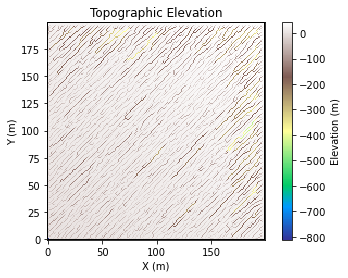

In [29]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [30]:
#Set elapsed time to zero
elapsed_time = 0

#Set timestep count to zero
count = 0

#Array to save sediment flux values and is currently filled with 0s
sed_flux = [0] * (run_time) 

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'][0] -= uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][0] = mg.at_node['bedrock__elevation'][0] + mg.at_node['soil__depth'][0] #changing the elevation to account for the uplift

    fa.run_one_step()
    sp.run_one_step(dt = timestep)
    sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]

    elapsed_time += timestep
    print(elapsed_time)
    count +=1
    '''
    #Instantiate figure as an empty plot
    fig = plt.figure()

    #Instantiate subplot as an empty plot
    sedfluxplot = plt.subplot()

    #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
    sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

    #Add axis labels to the plot 
    sedfluxplot.set_title('Sedimentograph') #title
    sedfluxplot.set_xlabel('Time [yr]') #x axis label
    sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label
    #fig.savefig("sed" + str(count) + ".png")'''

100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0
1100.0
1200.0
1300.0
1400.0
1500.0
1600.0
1700.0
1800.0
1900.0
2000.0
2100.0
2200.0
2300.0
2400.0
2500.0
2600.0
2700.0
2800.0
2900.0
3000.0
3100.0
3200.0
3300.0
3400.0
3500.0
3600.0
3700.0
3800.0
3900.0
4000.0
4100.0
4200.0
4300.0
4400.0
4500.0
4600.0
4700.0
4800.0
4900.0
5000.0
5100.0
5200.0
5300.0
5400.0
5500.0
5600.0
5700.0
5800.0
5900.0
6000.0
6100.0
6200.0
6300.0
6400.0
6500.0
6600.0
6700.0
6800.0
6900.0
7000.0
7100.0
7200.0
7300.0
7400.0
7500.0
7600.0
7700.0


KeyboardInterrupt: 

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

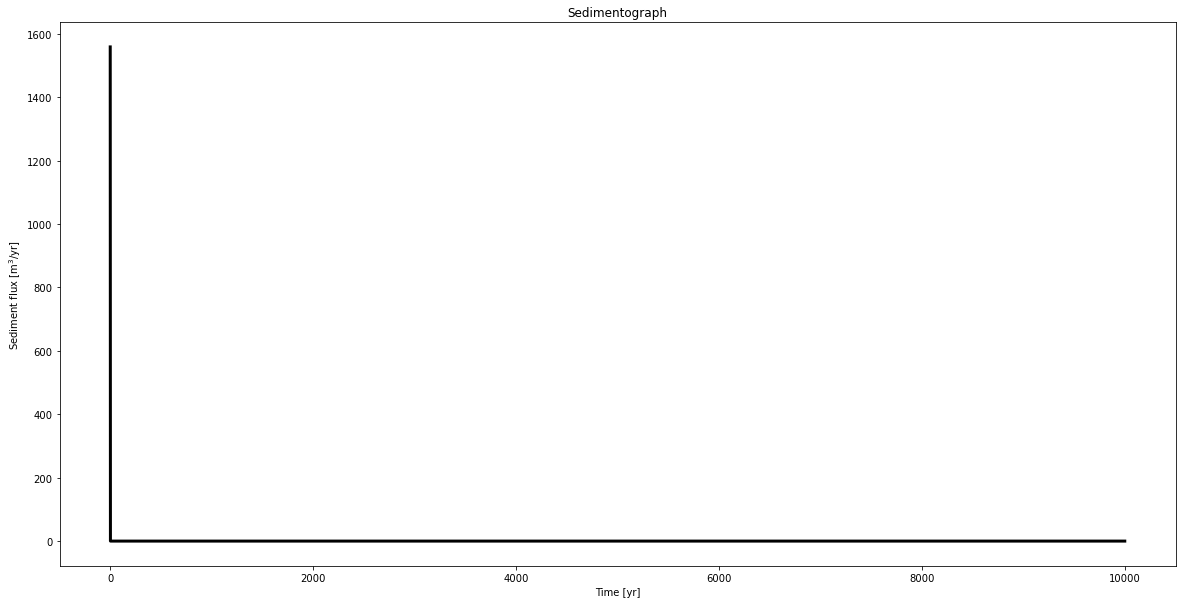

In [ ]:
#Instantiate figure as an empty plot
fig = plt.figure()

    #Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()
fig.set_size_inches(20, 10)
    #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

    #Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label
    #fig.savefig("sed" + str(count) + ".png")

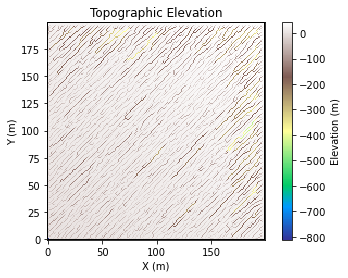

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [ ]:
prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

#Show the profile
plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)

ValueError: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [ 0.]

In [ ]:
#Instantiate figure as an empty plot
fig = plt.figure()

#Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()

#Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

#Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label